# Delay experiment with Steane Code (measurement in all the 7 qubits):

In this experiment we encode the state $\ket{0}_L$ in the Steane Code and measure with and whitout error correction, as in the experiments of $\text{./delay\_measureZL.ipynb}$. The key difference that we indroduce here is in the measurement, where instead of adding an extra qubit to measure the state in the observable $Z_L$ we measure the seven qubits in the computational state in order to reduce the depth of the circuit. 

To evaluate the correctness of the encoding process, instead of computing the *error rate*, we estimate the probability $\hat{p}_i$ of measuring the bitstring $i$ and compare this distribution with the theoretical disfribution when the state is encoded with no errors. We compare the two distribution using the total variation distance $\text{TVD}$. We know that with $2,500$ shots, we can ensure with $0.95$ probability that the error in our estimation $\widehat{\text{TVD}}$ of the total variation distance differs in at most $0.22$ with the real $\text{TVD}$.

In [1]:
import numpy as np
from qiskit.circuit import Delay
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService
import warnings
from qiskit.primitives import StatevectorSampler

import sys
import os

# Add "../../.." to the sys.path to use SteaneCodeCircuit class
sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))
from objects.steane_code_circuit import SteaneCodeCircuit
from functions.transpile import get_layout
from utils import get_transpile, TVD

In [2]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)

In [3]:
# Define the valid states for the experiment
valid_states = ['0000000', '0001111', '0110011', '0111100', '1010101', '1011010', '1100110', '1101001']
real_distribution = {}
for i in valid_states:
    real_distribution[i] = 1/8

print(f" > Expected distribution if there is no errors:\n {real_distribution}")

 > Expected distribution if there is no errors:
 {'0000000': 0.125, '0001111': 0.125, '0110011': 0.125, '0111100': 0.125, '1010101': 0.125, '1011010': 0.125, '1100110': 0.125, '1101001': 0.125}


### Experiment 1: 

We use the class $\textcolor{orange}{\text{SteaneCodeCircuit()}}$ to create a logical circuit using the Steane Code. Recall that this experiment consits of encoding the state $\ket{0}_L$, apply a time delay $t$ in all of the 7 qubits of the code and then measure the seven qubits in the computational basis. Therefore the experiment is as follows:

$$\text{Encode } \ket{0}_L \rightarrow \text{Delay}(t) \rightarrow \text{Measure }(\text{All 7 qubits in the computational basis})$$

We then compute the total variation distance between the estimated probabilities after $2,500$ shots of the circuits and the expected probabilities (printed in the cell above).

In [4]:
# Select backend
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
sampler = SamplerV2(backend)
shots = 12800

In [5]:
# Get the dt of the selected backend in nano seconds
print(f" > dt in seconds: {backend.configuration().dt} s")
dt = backend.configuration().dt * 10**9
print(f" > dt in ns: {round(dt, 3)} ns")

 > dt in seconds: 2.2222222222222221e-10 s
 > dt in ns: 0.222 ns


In [6]:
# Create a circuit with no delay to get the layout
qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
qc_steane.encode(append=True)
qc_steane.barrier()
qc_steane.measure_all("all") # Measure the 7 qubits

qc = qc_steane.physical_quantum_circuit
qc.draw("mpl")


isa_circuit = get_transpile(qc, backend, iterations=100, scheduling_method="asap", optimization_level=3)
initial_layout = get_layout(isa_circuit, qb_len=7)
print(f"layout: {initial_layout}")

layout: [60, 59, 53, 61, 58, 41, 71]


In [7]:
initial_layout = [60, 59, 53, 61, 58, 41, 71]

In [8]:
print(f" > Initial Layout: {initial_layout}")

 > Initial Layout: [60, 59, 53, 61, 58, 41, 71]


In [9]:
t_array = [t*9_000 for t in range(0, 100, 10)]
print(f" > Delays in dt: {t_array}")
print(f" > Delays un us: {[round(t*dt * 10**(-3) , 3) for t in t_array]}")

 > Delays in dt: [0, 90000, 180000, 270000, 360000, 450000, 540000, 630000, 720000, 810000]
 > Delays un us: [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0]


In [12]:
circuits = []
estimated_times = []

for t in t_array:
    # Generate circuit without error correction
    qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
    qc_steane.encode(append=True, initial_state='0')
    qc_steane.barrier()
    qc_steane.delay(t)
    qc_steane.barrier()

    qc_steane.measure_all("all")

    # Get and transpile physical_quantum_circuit
    qc = qc_steane.physical_quantum_circuit

    isa_circuit = get_transpile(qc, backend, scheduling_method="asap", optimization_level=1, initial_layout=initial_layout)
    circuits.append(isa_circuit)

    print(f"Circuit Depth: {isa_circuit.depth()}")
    print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")

    # QuantumCircuit.duration is deprecated. Ignore the warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        total_duration = isa_circuit.duration * dt * 10**(-3)
        print(f"Estimated Total Duration: {round(total_duration, 3)} us\n")

    estimated_times.append(total_duration)

Circuit Depth: 52
Delay Duration: 0.0 us
Estimated Total Duration: 10.126 us

Circuit Depth: 53
Delay Duration: 20.0 us
Estimated Total Duration: 30.126 us

Circuit Depth: 53
Delay Duration: 40.0 us
Estimated Total Duration: 50.126 us

Circuit Depth: 57
Delay Duration: 60.0 us
Estimated Total Duration: 70.716 us

Circuit Depth: 53
Delay Duration: 80.0 us
Estimated Total Duration: 90.126 us

Circuit Depth: 53
Delay Duration: 100.0 us
Estimated Total Duration: 110.126 us

Circuit Depth: 56
Delay Duration: 120.0 us
Estimated Total Duration: 130.716 us

Circuit Depth: 53
Delay Duration: 140.0 us
Estimated Total Duration: 150.126 us

Circuit Depth: 53
Delay Duration: 160.0 us
Estimated Total Duration: 170.126 us

Circuit Depth: 56
Delay Duration: 180.0 us
Estimated Total Duration: 190.716 us



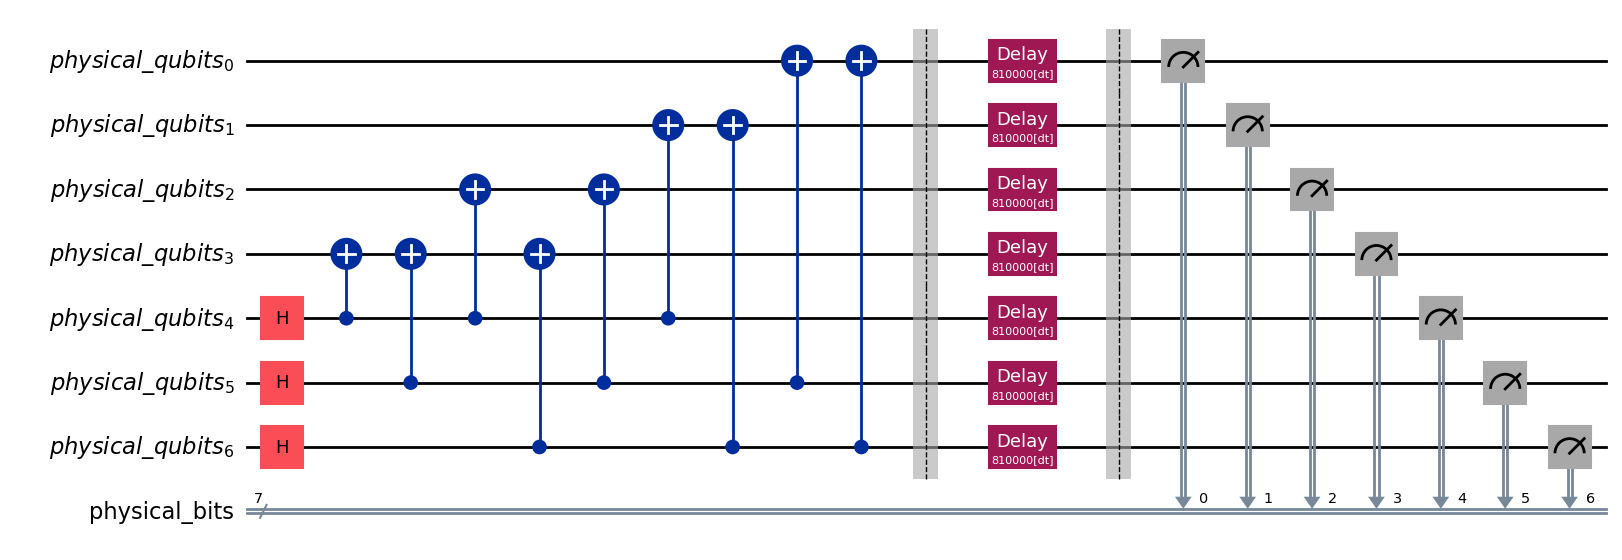

In [13]:
qc.draw("mpl")

In [ ]:
print(f" > Depth of original circuit (before transpilation): {qc.depth()}")

mean_depth = 0
for circ in circuits:
    mean_depth += circ.depth()

mean_depth = mean_depth/len(circuits)
    
print(f" > Mean depth of transpiled circuits: {mean_depth}")

#### Run simulation with $\text{StateVectorSampler()}$:

In [ ]:
# Run last circuit using StateVectorSampler
state_vector_sampler = StatevectorSampler()
state_vector_shots = 60_000 # Use 60_000 shots for state vector simulation
job = state_vector_sampler.run([qc], shots = 60000)
pub_result = job.result()

In [ ]:
print(f" > StateVector counts: {pub_result[0].data.physical_bits.get_counts()}")

In [ ]:
counts = pub_result[0].data.physical_bits.get_counts()
empirical_distribution = {}

# Recall that qiskit gives the result in reverse order:
for i in counts.keys():
    empirical_distribution[i[::-1]] = counts[i]/state_vector_shots

print(f" > Estimated TVD with StateVector simulation: {TVD(empirical_distribution, real_distribution)}")

#### Run circuit in real backend:

In [ ]:
# WARNING: This sends the circuit to run.
job = sampler.run(circuits, shots = shots)
job_id = job.job_id()

print(f" > job_id: {job_id}")
print(f" > job_status: {job.status()}")

In [ ]:
# Opening JSON file
import json

metadata = {'expected_distribution': real_distribution, 't_array': t_array, 'initial_layout':initial_layout, 'estimated_duration': estimated_times}
json_file = "experiments.json"

with open(json_file) as f:
    experiment_results = json.load(f)


if ("delay_measureAll_noCorrection" in experiment_results.keys()):
    # Check for repeated job_id. If job_id is not repeated we add the job to the json
    results = experiment_results["delay_measureAll_noCorrection"]
    if job_id not in [results[i]['job_id'] for i in range(len(results))]:
        experiment_results["delay_measureAll_noCorrection"].append({"job_id":job_id, "metadata":metadata})

else:
    experiment_results["delay_measureAll_noCorrection"] = [{"job_id":job_id, "metadata":metadata}]


# Writing back to JSON
with open(json_file, "w") as f:
    f.write(json.dumps(experiment_results, indent=2))

### Experiment 2: Circuit with error correction

This experiment is exactly the same as the first one, but we apply the error correction procedure of the Steane Code before the measurement in the computational basis. Therefore we can represent the experiment as follows:

$$\text{Encode } \ket{0}_L  \rightarrow \text{Delay}(dt) \rightarrow \text{Error-Correction} \rightarrow \text{Measure } (\text{All 7 qubits in the computational basis})$$

Again, we compute the Total Variation Distance as an indicator of the succes of the procedure.

In [ ]:
# Select backend
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
sampler = SamplerV2(backend)
shots = 2500

In [ ]:
# Get the dt of the selected backend in nano seconds
print(f" > dt in seconds: {backend.configuration().dt} s")
dt = backend.configuration().dt * 10**9
print(f" > dt in ns: {round(dt, 3)} ns")

In [ ]:
# Create a circuit with no delay to get the layout
qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
qc_steane.encode(append=True)
qc_steane.barrier()
qc_steane.correct(append=True)
qc_steane.barrier()
qc_steane.measure_all("all") # Measure the 7 qubits

qc = qc_steane.physical_quantum_circuit
qc.draw("mpl")


isa_circuit = get_transpile(qc, backend, iterations=10, scheduling_method="asap", optimization_level=3)
initial_layout = get_layout(isa_circuit, qb_len=13)

# Use pre-defined layout:
initial_layout = [118, 119, 110, 117, 100, 120, 99, 101, 98, 102, 91, 97, 79]


In [ ]:
print(f" > Initial Layout: {initial_layout}")

In [ ]:
t_array = [t*9_000 for t in range(0, 6)]
print(f" > Delays in dt: {t_array}")
print(f" > Delays un us: {[round(t*dt * 10**(-3) , 3) for t in t_array]}")

In [ ]:
circuits = []

for t in t_array:
    # Generate circuit without error correction
    qc_steane = SteaneCodeCircuit(logical_qubit_count=1)
    qc_steane.encode(append=True)
    for i in range(qc_steane.physical_qubit_count):
        qc_steane.append_unitary_error(Delay(t), i)

    qc_steane.correct(append=True)

    qc_steane.measure_all("all")

    # Get and transpile physical_quantum_circuit
    qc = qc_steane.physical_quantum_circuit

    isa_circuit = get_transpile(qc, backend, scheduling_method="asap", optimization_level=3, initial_layout=initial_layout)
    circuits.append(isa_circuit)

    print(f"Circuit Depth: {isa_circuit.depth()}")
    print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")

    # QuantumCircuit.duration is deprecated. Ignore the warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        total_duration = isa_circuit.duration * dt * 10**(-3)
        print(f"Estimated Total Duration: {round(total_duration, 3)} us\n")

In [ ]:
qc.draw("mpl")

In [ ]:
print(f" > Depth of original circuit (before transpilation): {qc.depth()}")

mean_depth = 0
for circ in circuits:
    mean_depth += circ.depth()

mean_depth = mean_depth/len(circuits)
    
print(f" > Mean depth of transpiled circuits: {mean_depth}")

In [ ]:
# WARNING: This sends the circuit to run.
job = sampler.run(circuits, shots = shots)
job_id = job.job_id()

print(f" > job_id: {job_id}")
print(f" > job_status: {job.status()}")

In [ ]:
# Opening JSON file
import json

metadata = {'expected_distribution': real_distribution, 't_array': t_array, 'initial_layout':initial_layout}
json_file = "experiments.json"

experiment_name = "delay_measureAll_Correction"

with open(json_file) as f:
    experiment_results = json.load(f)


if (experiment_name in experiment_results.keys()):
    # Check for repeated job_id. If job_id is not repeated we add the job to the json
    results = experiment_results[experiment_name]
    if job_id not in [results[i]['job_id'] for i in range(len(results))]:
        experiment_results[experiment_name].append({"job_id":job_id, "metadata":metadata})

else:
    experiment_results[experiment_name] = [{"job_id":job_id, "metadata":metadata}]


# Writing back to JSON
with open(json_file, "w") as f:
    f.write(json.dumps(experiment_results, indent=2))